In [69]:
%matplotlib inline
import sys
# this cumbersome syntax is so that path to my code is prepended instead of appended
sys.path = ['..'] + sys.path

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
import dolfin as d
import numpy as np

from atexpmesh import ArcTanExpMesh
from atplmesh import ArcTanPowerLawMesh

from fem import Fem
from tophatsource import TopHatSource, StepSource

from UV import UVFields, UVSolver
from IR import IRFields, IRSolver
from gravity import PoissonSolver

from utils import project, get_values

# for this notebook
from scipy.special import binom 
from copy import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [71]:
# UV theory
UV_mesh = ArcTanExpMesh( num_cells=250, k=3., b=1e-2, 
                     linear_refine=2, linear_start=1.05, linear_stop=1.2, adjust_transition=True )
UV_fem = Fem( UV_mesh, func_degree=5 )
UV_source = TopHatSource( UV_fem, Ms=1e10, Rs=1e47, w=0.02 )
UV_fields = UVFields( m=1e-48, M=1e-46 )
uvs = UVSolver( UV_fem, UV_source, UV_fields, Mf1=1e13, Mf2=1e12, 
                rel_res_tol=1e-100, abs_res_tol=1e-83, max_iter=50 )
uvs.solve()

Non-linear solver, iteration 0	abs_du = 1.0e-51	rel_du = 4.3e-01	abs_res = 8.8e-43 (tol = 1.0e-83)	rel_res = 1.0e+00 (tol = 1.0e-100)
Non-linear solver, iteration 1	abs_du = 6.9e-52	rel_du = 2.9e-01	abs_res = 2.6e-43 (tol = 1.0e-83)	rel_res = 3.0e-01 (tol = 1.0e-100)
Non-linear solver, iteration 2	abs_du = 4.6e-52	rel_du = 1.9e-01	abs_res = 7.8e-44 (tol = 1.0e-83)	rel_res = 8.8e-02 (tol = 1.0e-100)
Non-linear solver, iteration 3	abs_du = 3.0e-52	rel_du = 1.3e-01	abs_res = 2.3e-44 (tol = 1.0e-83)	rel_res = 2.6e-02 (tol = 1.0e-100)
Non-linear solver, iteration 4	abs_du = 2.0e-52	rel_du = 8.5e-02	abs_res = 6.8e-45 (tol = 1.0e-83)	rel_res = 7.7e-03 (tol = 1.0e-100)
Non-linear solver, iteration 5	abs_du = 1.4e-52	rel_du = 5.7e-02	abs_res = 2.0e-45 (tol = 1.0e-83)	rel_res = 2.3e-03 (tol = 1.0e-100)
Non-linear solver, iteration 6	abs_du = 9.0e-53	rel_du = 3.8e-02	abs_res = 6.0e-46 (tol = 1.0e-83)	rel_res = 6.8e-04 (tol = 1.0e-100)
Non-linear solver, iteration 7	abs_du = 6.0e-53	rel_du = 2.5e-

In [72]:
# IR theory
mesh = ArcTanPowerLawMesh( num_cells=2300, k=15., gamma=8, r_rm=None, A_rm=20., k_rm=30., r_max=1e13,
                         adjust_transition=True )
fem = Fem( mesh, func_degree=7 )
source = TopHatSource( fem, Ms=11e28, Rs=7e49, w=0.02 )
fields = IRFields( m=1e-56, Lambda=1e-46, epsilon=3e-3, n=3 )
irs = IRSolver( fem, source, fields, Mf1=1e-35, rel_res_tol=1e-100, abs_res_tol=1e-10,
               max_iter=30 )
irs.solve()

Getting NL initial guess...
Non-linear solver, iteration 0	abs_du = 3.0e+26	rel_du = 4.2e+09	abs_res = 1.1e+39 (tol = 1.0e-10)	rel_res = 1.0e+00 (tol = 1.0e-100)
Non-linear solver, iteration 1	abs_du = 4.4e+13	rel_du = 6.1e-04	abs_res = 1.7e+19 (tol = 1.0e-10)	rel_res = 1.5e-20 (tol = 1.0e-100)
Non-linear solver, iteration 2	abs_du = 3.8e+11	rel_du = 5.2e-06	abs_res = 3.1e+17 (tol = 1.0e-10)	rel_res = 2.8e-22 (tol = 1.0e-100)
Non-linear solver, iteration 3	abs_du = 7.3e+09	rel_du = 1.0e-07	abs_res = 7.4e+15 (tol = 1.0e-10)	rel_res = 6.7e-24 (tol = 1.0e-100)
Non-linear solver, iteration 4	abs_du = 1.6e+08	rel_du = 2.2e-09	abs_res = 1.2e+14 (tol = 1.0e-10)	rel_res = 1.1e-25 (tol = 1.0e-100)
Non-linear solver, iteration 5	abs_du = 3.4e+06	rel_du = 4.7e-11	abs_res = 1.2e+12 (tol = 1.0e-10)	rel_res = 1.1e-27 (tol = 1.0e-100)
Non-linear solver, iteration 6	abs_du = 3.1e+06	rel_du = 4.3e-11	abs_res = 2.6e+08 (tol = 1.0e-10)	rel_res = 2.4e-31 (tol = 1.0e-100)
Non-linear solver, iteration 7	abs

In [73]:
# order of the operator - p in this notebook to distinguish between irs param n and mass param m
p = 3


In [74]:
# UV theory - phi-enics prediction
On_Phi = uvs.On( p, rescale=1e40 )
UV_r_values, UV_On_values = get_values( On_Phi, output_mesh=True )

In [75]:
# UV theory - source dominated

cp = (-1)**(p+1) * binom(3*p,p) * uvs.fields.alpha**(2*p+2) * (uvs.fields.lam/6.)**p

# Y ~ rho/Mp + m^2 phi at small r, leading term propto Del Phi
source_On = d.Expression('cp * pow(rho/Mp * pow(Mn/M,3),2*p) * pow(m/M,2) * Y', 
                      degree=uvs.fem.func_degree, cp=cp,
                      rho=uvs.source.rho, Mp=uvs.fields.Mp, 
                      Mn=uvs.Mn, m=uvs.fields.m, M=uvs.fields.M,
                      p=p, Y=uvs.Y )
source_On = d.interpolate( source_On, uvs.fem.S )
UV_source_On_values = get_values( source_On )

In [76]:
# UV theory - source vacuum transition

cp = (-1)**p * binom(3*p,p)

rhobar = d.Expression('pow(exp((x[0]-rs)/w)+1.,-1)', degree=uvs.fem.func_degree,
                     rs=uvs.source.t * uvs.fem.mesh.rs, w=uvs.source.w )

code = 'cp * pow(alpha,2*p+2) * pow(lam/6.,p) * pow(Mn/M,6*p+2) * pow(Mn,3) * pow(rho/Mp,2*p+1) * ' + \
    'rhobar * exp((x[0]-rs)/w)/w * ( 2./x[0] + 1./w - 2.*(p-1)/w * rhobar * exp((x[0]-rs)/w) )'
    
rho_On_th = d.Expression(code, degree=uvs.fem.func_degree, 
                         w=uvs.source.w, rho=uvs.source.rho,
                         rs= uvs.source.t * uvs.fem.mesh.rs,
                         Mn=uvs.Mn, M=uvs.fields.M, alpha=uvs.fields.alpha, 
                         lam=uvs.fields.lam, cp=cp, p=p,
                         Mp=uvs.fields.Mp, rhobar=rhobar )

rho_On_th = d.interpolate( rho_On_th, uvs.fem.S )
UV_rho_On_th_values = get_values( rho_On_th )


In [77]:
# UV theory - Yukawa suppressed

cp = (-1)**(p+1) * binom(3*p,p)

r_piv = 10.
c_piv = uvs.phi(r_piv) * r_piv / np.exp( -uvs.fields.m / uvs.Mn * r_piv )

code = 'cp * pow(alpha,2*p+2) * pow(lam/6.,p) * pow(pow(m/M,2) * Mf1*c_piv/M,2*p+1) * pow(Mn,2) * M * ' + \
'pow(exp(-m/Mn*x[0])/x[0],2*p+1) * ( (2.*p+1.) * pow(m/Mn,2) + 2*p/pow(x[0],2) + 4.*p*m/Mn/x[0] )'

UV_Yukawa_On_th = d.Expression( code, degree=uvs.fem.func_degree, 
                               cp=cp, c_piv=c_piv, 
                               m=uvs.fields.m, M=uvs.fields.M, alpha=uvs.fields.alpha, 
                               lam=uvs.fields.lam,
                               p=p, Mn=uvs.Mn, Mf1=uvs.Mf1 )

UV_Yukawa_On_th = d.interpolate( UV_Yukawa_On_th, uvs.fem.S )
UV_Yukawa_On_th_values = get_values( UV_Yukawa_On_th )


In [78]:
# UV theory - heavy field dominated regime

# Y ~ H^3
H_uvs = copy( uvs )
y = d.Expression('-lam/6./alpha * pow(Mf2/Mn,2) * Mf2/Mf1 * pow(h,3)', 
                 degree=uvs.fem.func_degree, Mn=uvs.Mn, Mf2=uvs.Mf2, Mf1=uvs.Mf1,
                alpha=uvs.fields.alpha, lam=uvs.fields.lam,
                h=uvs.h )
y = d.interpolate( y, uvs.fem.S )
H_uvs.y = y

H_On = H_uvs.On( p, rescale=1e50 )
UV_H_On_values = get_values( H_On )


# Y ~ H^3 and DelH
H_Z_uvs = copy( uvs )

y = d.Expression('1./alpha * Mf2/Mf1 * z - lam/6./alpha * pow(Mf2/Mn,2) * Mf2/Mf1 * pow(h,3)', 
                 degree=uvs.fem.func_degree, Mn=uvs.Mn, Mf2=uvs.Mf2, Mf1=uvs.Mf1,
                alpha=uvs.fields.alpha, lam=uvs.fields.lam,
                h=uvs.h, z=uvs.z )
y = d.interpolate( y, uvs.fem.S )
H_Z_uvs.y = y

H_Z_On = H_Z_uvs.On( p, rescale=1e50 )
UV_H_Z_On_values = get_values( H_Z_On )


In [79]:
# IR theory - phi-enics prediction
On_Pi = irs.On( p, rescale=1e0 )
IR_r_values, IR_On_values = get_values( On_Pi, output_mesh=True )

In [80]:
# IR theory - deep nonlinear regime

code = '''
class On_NL_th : public Expression
{
public:

  double cp, epsilon, Mp, Lambda, Ms, rs, Mn, Mf1 ;
  int p, n;

  On_NL_th() : Expression()
  {
  }

  void eval(Array<double>& values, const Array<double>& x) const
  {
    
    double beta = (2.*p+1.)/n ;
                                                
    if ( x[0] < rs + DOLFIN_EPS ) {
        values[0] = cp * pow(epsilon,p) * pow(Mn,2) * Lambda * pow(Mn/Lambda,beta) * \
        pow( Ms/(8.*pi*rs*epsilon*Mp), beta) * 2.*beta/pow(rs,2) * \
        pow( 3. - pow(x[0]/rs,2), beta-2. ) * ( -9. + (1.+2*beta) * pow(x[0]/rs,2) ) ;
    }
    
    else {
        values[0] = cp * beta * (beta-1.) * pow(epsilon,p) * pow(Mn,2) * Lambda * \
        pow(Mn/Lambda,beta) * pow( Ms/(4.*pi*epsilon*Mp), beta ) / pow(x[0],beta+2) ;
    }
  }
};
'''    
    
cp = (-1)**(p+1) * binom(3*p, p) /(2.*p+1.)
    
NL_On_th = d.Expression( code, degree=irs.fem.func_degree, Ms=irs.source.Ms,
                    Lambda=irs.fields.Lambda, epsilon=irs.fields.epsilon,
                    n=irs.fields.n, Mn=irs.Mn, Mf1=irs.Mf1, p=p, 
                    rs=irs.source.t * irs.fem.mesh.rs, Mp=irs.fields.Mp, cp=cp )
    
NL_On_th = d.interpolate( NL_On_th, irs.fem.S )
IR_r_values, IR_NL_On_th_values = get_values( NL_On_th, output_mesh=True )

In [81]:
# IR theory - Yukawa suppression
cp = (-1)**(p+1) * binom(3*p,p)

r_piv = 1e4
c_piv = irs.pi(r_piv) * r_piv / np.exp( -irs.fields.m / irs.Mn * r_piv ) 

code = 'cp * pow(epsilon,p) * pow(pow(m/Lambda,2) * Mf1*c/Lambda,2*p+1) * pow(Mn,2) * Lambda * ' + \
'pow(exp(-m/Mn*x[0])/x[0],2*p+1) * ( (2.*p+1.) * pow(m/Mn,2) + 2*p/pow(x[0],2) + 4.*p*m/Mn/x[0] )'

Yukawa_On_th = d.Expression( code, degree=irs.fem.func_degree,
                          cp=cp, c=c_piv, m=irs.fields.m, Lambda=irs.fields.Lambda, 
                            epsilon=irs.fields.epsilon,
                           p=p, Mn=irs.Mn, Mf1=irs.Mf1)

Yukawa_On_th = d.interpolate( Yukawa_On_th, irs.fem.S )
IR_Yukawa_On_th_values = get_values( Yukawa_On_th )


Text(0,0.5,u'$|O_{3}|=|12 \\alpha^{7} \\lambda^{3} {m_H}^{20} \\nabla^2 ((\\nabla^2\\phi)^{7}) |$')

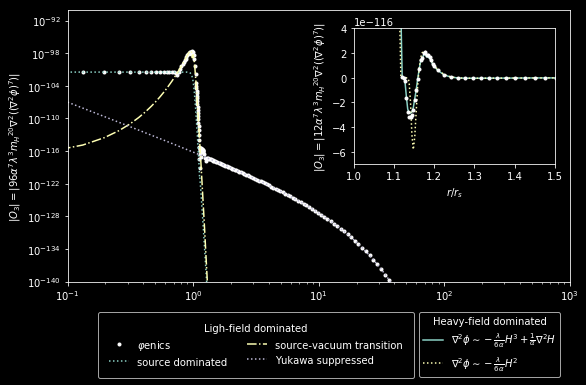

In [82]:
# UV picture

fig = plt.figure(figsize=(9,5))

plt.plot( UV_r_values, abs(UV_On_values), 'w.', label=r'$\varphi$enics' )
plt.plot( UV_r_values, abs(UV_source_On_values), ':', label='source dominated')
plt.plot( UV_r_values, abs(UV_rho_On_th_values), '-.', label='source-vacuum transition')
plt.plot( UV_r_values, abs(UV_Yukawa_On_th_values), ':', label=r'Yukawa suppressed')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,1e3)
plt.ylim(1e-140,1e-90)
plt.legend(title='Ligh-field dominated', ncol=2, bbox_to_anchor=(0.2,-0.093,0.5,0.), 
           fancybox=True, borderpad=1.1)
plt.ylabel(r'$|O_{%d}|=|%.0f \alpha^{%d} \lambda^{%d} {m_H}^{%d} \nabla^2 ((\nabla^2\phi)^{%d}) |$'
           % ( p, binom(3*p,p) * (2*p+2)/(2*p+1), 2*p+1, p, 6*p+2, 2*p+1 ) )
#plt.xlabel(r'$r/r_s$')

# inset with H equation
ax = plt.gca()
#axins2 = inset_axes(ax, width="40%", height="40%", loc=1)
axins2 = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.58, .45, .4, .5),
                   bbox_transform=ax.transAxes, loc=1)
axins2.plot( UV_r_values, UV_H_Z_On_values, '-', label=r'$\nabla^2\phi\sim -\frac{\lambda}{6\alpha}H^3+\frac{1}{\alpha}\nabla^2 H$' )
axins2.plot( UV_r_values, UV_H_On_values, ':', label=r'$\nabla^2\phi\sim-\frac{\lambda}{6\alpha}H^2$')
axins2.plot( UV_r_values, UV_On_values, 'w.' )
axins2.set_xlim(1.,1.5)
axins2.set_ylim(-7e-116,4e-116)
axins2.set_xlabel(r'$r/r_s$')
#axins2.legend(ncol=4, bbox_to_anchor=(-1.35,-1.4), loc=2)
axins2.legend(title='Heavy-field dominated', ncol=1, bbox_to_anchor=(0.3,-1.05))
#axins2.set_ylabel(r'$|O_{%d}|$' % n)
axins2.set_ylabel(r'$|O_{%d}|=|%.0f \alpha^{%d} \lambda^{%d} {m_H}^{%d} \nabla^2 ((\nabla^2\phi)^{%d}) |$'
           % ( p, binom(3*p,p) /(2*p+1), 2*p+1, p, 6*p+2, 2*p+1 ) )



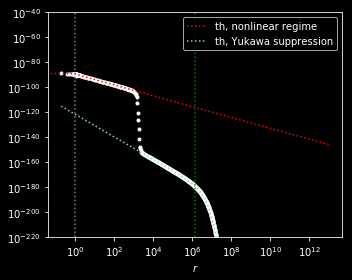

In [83]:
# IR picture

fig = plt.figure(figsize=(5,4))

plt.plot( IR_r_values, abs(IR_On_values), 'w.' )
plt.plot( IR_r_values, abs(IR_NL_On_th_values), 'r:', label='th, nonlinear regime' )
plt.plot( IR_r_values, abs(IR_Yukawa_On_th_values), ':', label='th, Yukawa suppression')
plt.xlabel(r'$r$')
# plot a vertical line where the transition source-vacuum happens
plt.axvline(x=irs.fem.mesh.rs, color='grey', linestyle=':')
plt.axvline(x=irs.Mn/irs.fields.m, linestyle=':', color='green')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-220, 1e-40)
#plt.xlim(1e-2, 1e3)
plt.legend()
plt.tight_layout()
    
    

In [84]:
# save arrays for off-docker picture
root = './data/On_UV_wiggles_'
np.save( root + 'r_values', UV_r_values )
np.save( root + 'On_values', UV_On_values )
np.save( root + 'source_On_th_values', UV_source_On_values )
np.save( root + 'rho_On_th_values', UV_rho_On_th_values )
np.save( root + 'Yukawa_On_th_values', UV_Yukawa_On_th_values )
np.save( root + 'H_On_values', UV_H_On_values )
np.save( root + 'H_Z_On_values', UV_H_Z_On_values )

In [85]:
# save arrays for off-docker picture
root = './data/On_IR_Antares_'
np.save( root + 'r_values.npy', IR_r_values )
np.save( root + 'On_values.npy', IR_On_values )
np.save( root + 'IR_NL_On_th_values.npy', IR_NL_On_th_values )
np.save( root + 'IR_Yukawa_On_th_values.npy', IR_Yukawa_On_th_values )